## Cardiovascular Disease Bayesian Network

### Cardiovascular disease topic
Intro to cardiovascular deasease

### What's a Bayesian Network?
Sprazi di teoria

### Why a Bayesian Network?
Spiegare perché si è scelta

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Dataset
Piccola intro sul dataset

In [2]:
df = pd.read_csv('cardio_dataset.csv', sep=';')

#### Dataset Analysis

##### Description

In [3]:
# Shows first dataframe rows
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
# 'age' column to years
df['age'] = (df['age'] / 365).astype(int)

# to int
df['weight'] = df['weight'].astype(int)

# renaming cardio in cardio_disease
df = df.rename(columns={'cardio': 'cardio_disease'})

In [5]:
df.describe().round(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
count,70000.00,70000.00,70000.00,70000.00,70000.0,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.0,70000.0
mean,49972.42,52.84,1.35,164.36,74.2,128.82,96.63,1.37,1.23,0.09,0.05,0.8,0.5
std,28851.30,6.77,0.48,8.21,14.4,154.01,188.47,0.68,0.57,0.28,0.23,0.4,0.5
min,0.00,29.00,1.00,55.00,10.0,-150.00,-70.00,1.00,1.00,0.00,0.00,0.0,0.0
25%,25006.75,48.00,1.00,159.00,65.0,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
50%,50001.50,53.00,1.00,165.00,72.0,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
75%,74889.25,58.00,2.00,170.00,82.0,140.00,90.00,2.00,1.00,0.00,0.00,1.0,1.0
max,99999.00,64.00,2.00,250.00,200.0,16020.00,11000.00,3.00,3.00,1.00,1.00,1.0,1.0


In [5]:
# Check null values
df.isnull().sum()

id                0
age               0
gender            0
height            0
weight            0
ap_hi             0
ap_lo             0
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio_disease    0
dtype: int64

##### Distribution Analysis

Numeric variable distribution

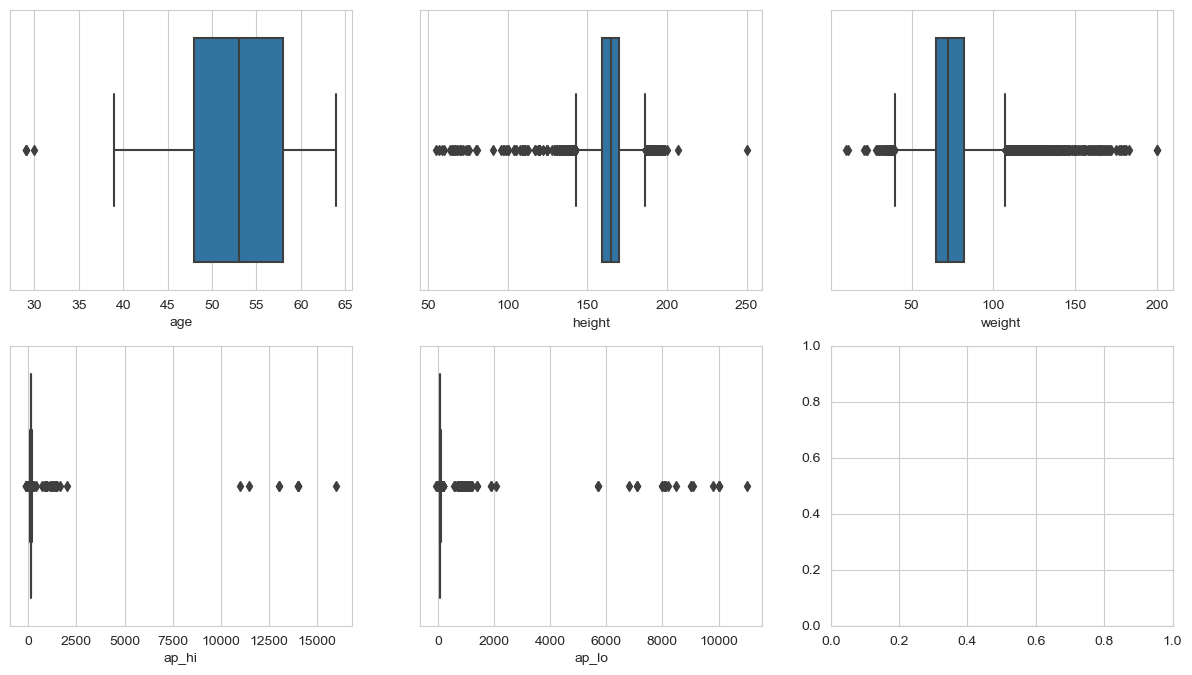

In [6]:
# Select the numeric columns
numeric_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]

# Create boxplots for numeric columns
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_xlabel(col)

##### Remove Outliers
The above boxplots show the presence of several outliers. Considering the dataset of 70K samples, it is reasonable to assume that there are some exceptional cases related to physical conditions. Below, we use the Interquartile range (IQR) method to analyze the outliers of height.

In [5]:
def outliers(df, feature):
    # Calcolo del primo e terzo quartile delle variabili numeriche
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    # Definizione del limite inferiore e superiore per ogni variabile numerica
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    ls = df.index[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return ls

index_list = []
for feature in ["age", "height", "weight", "ap_hi", "ap_lo"]:
    index_list.extend(outliers(df, feature))
len(index_list)


8409

In [6]:
def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

df = remove(df, index_list)
print("Numero di outlier rimossi:", len(index_list))
print("Numero di righe rimaste:", len(df))

Numero di outlier rimossi: 8409
Numero di righe rimaste: 62502


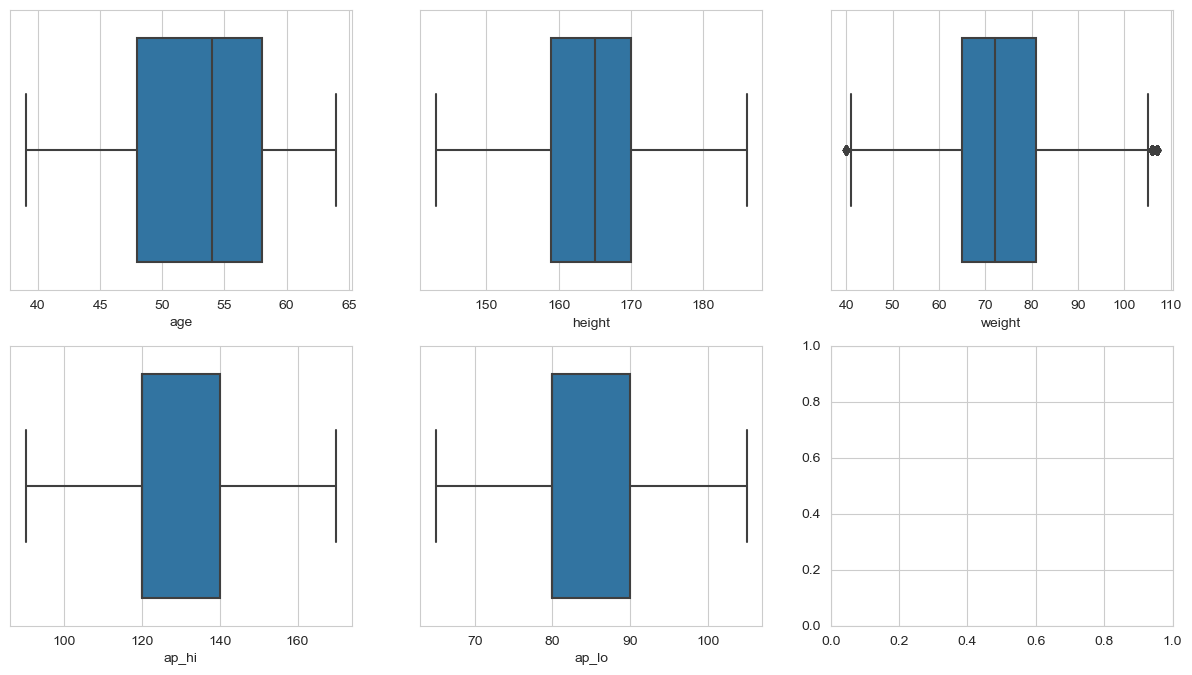

In [7]:
# Select the numeric columns
numeric_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]

# Create boxplots for numeric columns
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_xlabel(col)

In [8]:
df.describe().round(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
count,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.0,62502.00
mean,49941.88,52.91,1.35,164.41,73.18,126.42,81.70,1.36,1.22,0.09,0.05,0.8,0.49
std,28864.47,6.74,0.48,7.53,12.27,14.29,7.67,0.68,0.57,0.28,0.22,0.4,0.50
min,0.00,39.00,1.00,143.00,40.00,90.00,65.00,1.00,1.00,0.00,0.00,0.0,0.00
25%,24876.50,48.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.00
50%,49980.50,54.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.00
75%,74848.75,58.00,2.00,170.00,81.00,140.00,90.00,1.00,1.00,0.00,0.00,1.0,1.00
max,99999.00,64.00,2.00,186.00,107.00,170.00,105.00,3.00,3.00,1.00,1.00,1.0,1.00


Binary and class distribution

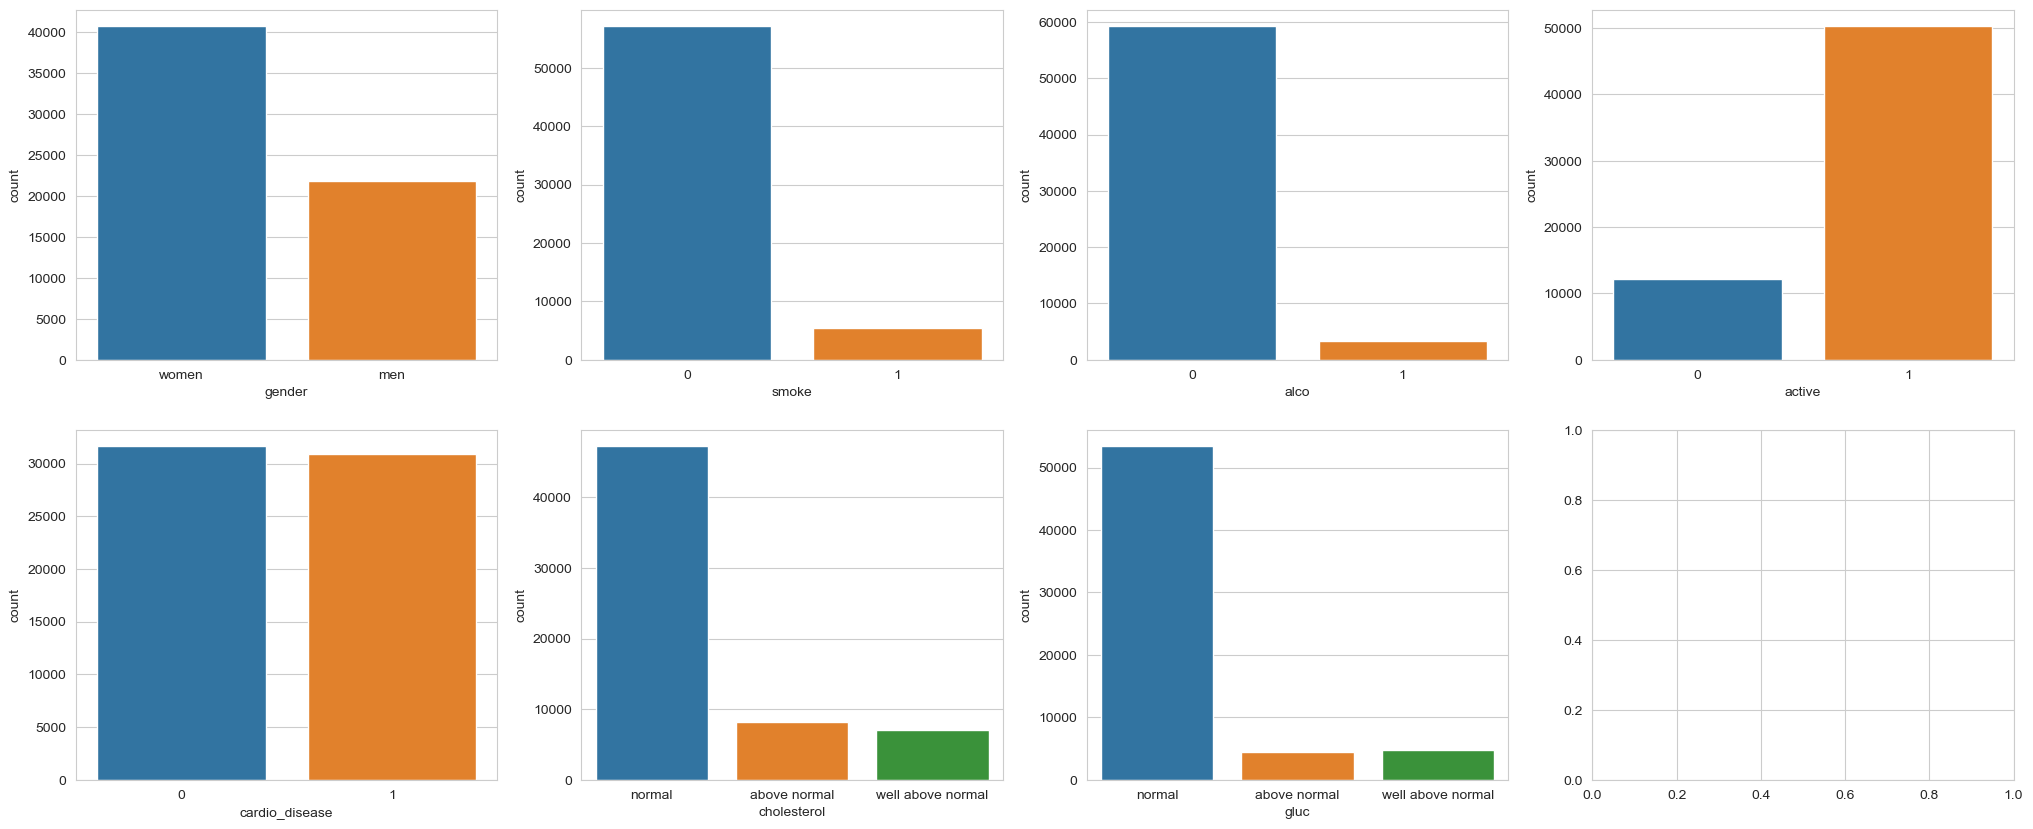

In [9]:
binary_cols = ["gender", "smoke", "alco", "active", "cardio_disease"]
cat_cols = ["cholesterol", "gluc"]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
axes = axes.flatten()

for i, col in enumerate(binary_cols + cat_cols):
    if col == "gender":
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xticklabels(["women", "men"])
    elif col in cat_cols:
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xticklabels(["normal", "above normal", "well above normal"])
    else:
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xlabel(col)


##### Correlation Matrix

Check the correlation among variables through a Pearson correlation matrix heatmap.

Text(0.5, 1.0, 'Correlation Heatmap')

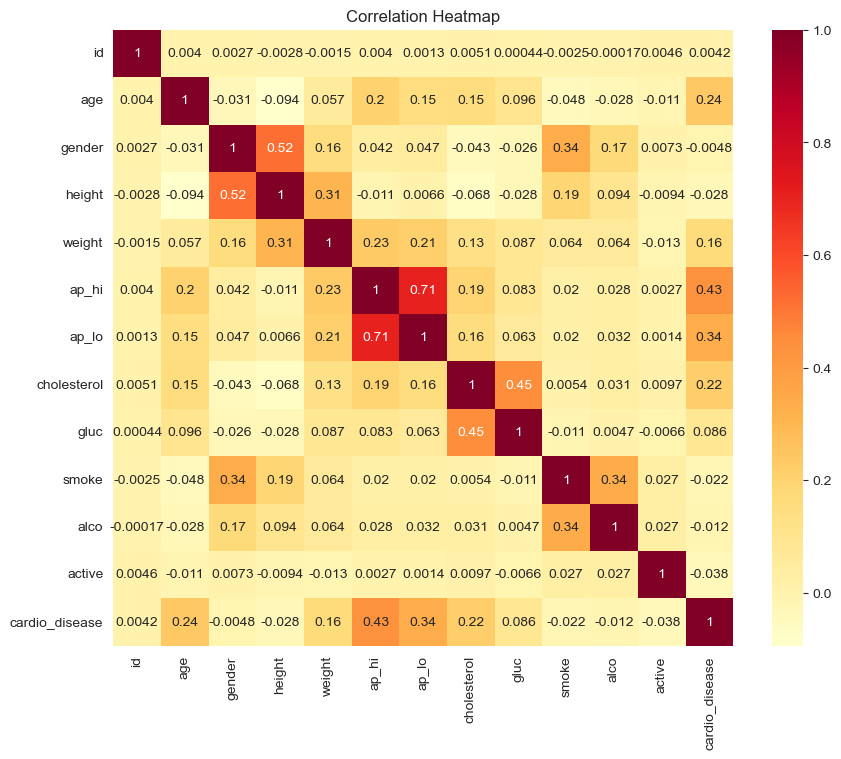

In [11]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(df.corr(), annot=True, ax=ax, cmap="YlOrRd")
plt.title("Correlation Heatmap")

From the above correlation heatmap, some pairs of variables with a positive correlation can be observed, such as:
- (age, cardio_disease)
- (gender, height)
- (gender, smoke)
- (height, weight)
- (weight, cardio_disease)
- (weight, ap_hi)
- (weight, ap_lo)
- (ap_hi, ap_lo)
- (ap_hi, cardio_disease)
- (ap_lo, cardio_disease)
- (cholesterol, gluc)
- (cholesterol, cardio_disease)
- (smoke, alco)

Therefore, there is a certain correlation between the variables, specifically in the case of cardiovascular diseases, a positive correlation is observed with increasing age, weight, ap_hight, ap_low, cholesterol, and partly with glucose.

### Split dataset into trainset and testset

In [12]:
df = df.drop('id', axis=1)

In [13]:
# split dataset into 90-10
train_set, test_set = train_test_split(df, test_size=0.1)

# save to csv
test_set.to_csv('cardio_test_set.csv', index=False, sep=";")
train_set.to_csv('cardio_train_set.csv', index=False, sep=";")

In [14]:
train_data = pd.read_csv('cardio_train_set.csv', sep=';')
test_data = pd.read_csv('cardio_test_set.csv', sep=';')

#### Check trainset distribution

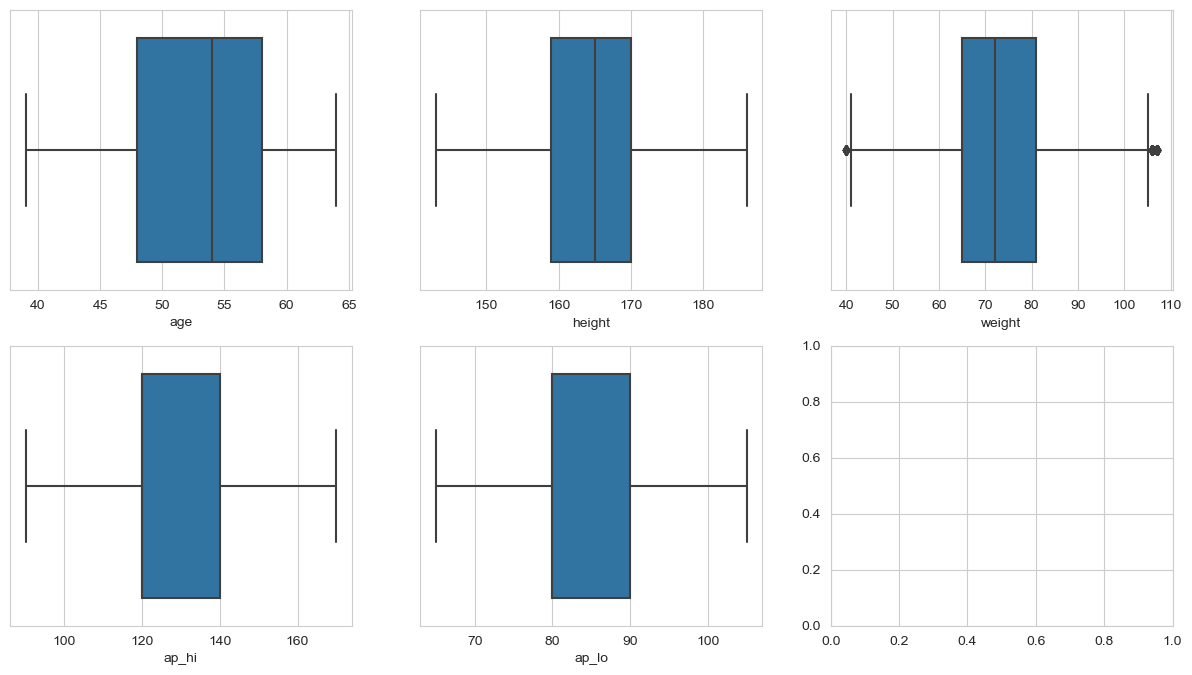

In [15]:
# Select the numeric columns
numeric_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]

# Create boxplots for numeric columns
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=train_data[col], ax=axes[i])
    axes[i].set_xlabel(col)

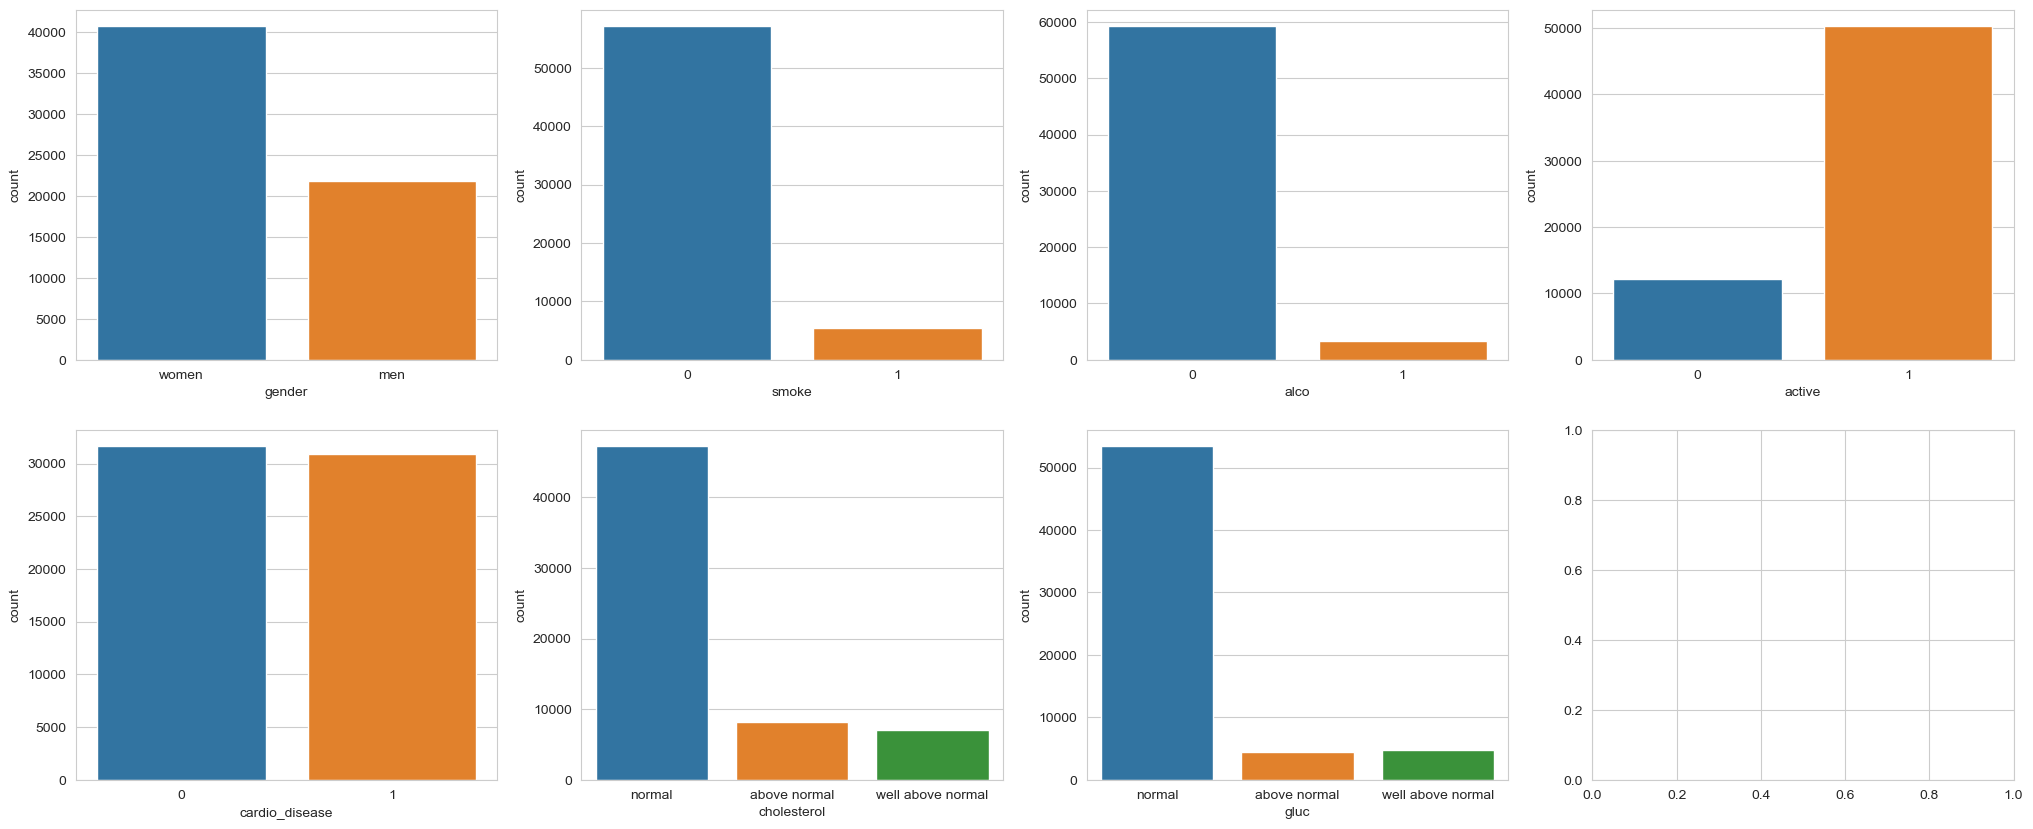

In [16]:
binary_cols = ["gender", "smoke", "alco", "active", "cardio_disease"]
cat_cols = ["cholesterol", "gluc"]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
axes = axes.flatten()

for i, col in enumerate(binary_cols + cat_cols):
    if col == "gender":
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xticklabels(["women", "men"])
    elif col in cat_cols:
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xticklabels(["normal", "above normal", "well above normal"])
    else:
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xlabel(col)

### Build a Bayesian Network

##### Hill Climbing Alghoritm

  0%|          | 0/1000000 [00:00<?, ?it/s]

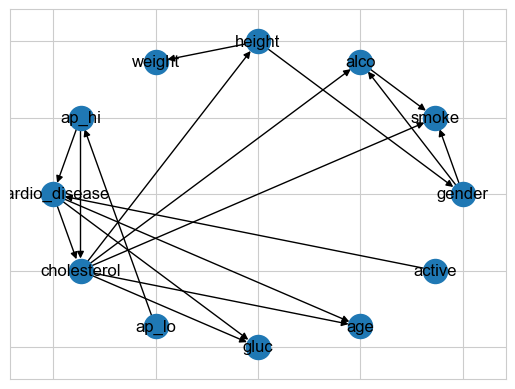

In [48]:
from pgmpy.estimators import HillClimbSearch
import networkx as nx
import matplotlib.pyplot as plt

hc = HillClimbSearch(train_data)
best_model = hc.estimate(scoring_method="k2score")

# crea il grafo diretto utilizzando la libreria networkx
graph = nx.DiGraph()
graph.add_edges_from(best_model.edges())

# disegna il grafo
pos = nx.circular_layout(graph)
nx.draw_networkx(graph, pos=pos, with_labels=True)
plt.show()

##### Bayesian Network model training

In [49]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

# Creazione della rete bayesiana
model = BayesianNetwork(best_model.edges())

# Apprendimento dei parametri della rete bayesiana dai dati di addestramento
model.fit(data=train_data, estimator=MaximumLikelihoodEstimator)

##### Model evaluation

In [50]:
from sklearn.metrics import accuracy_score

# Genera le previsioni del modello sui dati di test
prediction_dataset = test_data.drop(["cardio_disease"], axis=1)
y_pred = model.predict(prediction_dataset)

# Ottieni le etichette reali dal dataset di test
y_true = test_data['cardio_disease'].values

# Calcola l'accuracy del modello
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy:", accuracy)


  0%|          | 0/6172 [00:00<?, ?it/s]

/Users/danilosantitto/miniconda3/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/Users/danilosantitto/miniconda3/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Accuracy: 0.7288433850583906


##### Inference Test

In [51]:
infer = VariableElimination(model)

# Esempio: probabilità di cardio = 1 (cioè malattia cardiovascolare) avendo un paziente di 60 anni, di genere maschile, alto 170 cm, peso 70 kg, con pressione sistolica di 120, pressione diastolica di 80, colesterolo 1, glucosio 1, non fumatore, non alcolista, attivo
q = infer.query(variables=['cardio_disease'], evidence={'age': 50, 'gender': 1, 'height': 159, 'weight': 60, 'ap_hi': 108, 'ap_lo': 75, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1})
print(q)

+-------------------+-----------------------+
| cardio_disease    |   phi(cardio_disease) |
+===================+=======================+
| cardio_disease(0) |                   nan |
+-------------------+-----------------------+
| cardio_disease(1) |                   nan |
+-------------------+-----------------------+


age             50
gender           1
height         159
weight          60
ap_hi          108
ap_lo           75
cholesterol      1
gluc             1
smoke            0
alco             0
active           1
Name: 179, dtype: int64

In [28]:
import bnlearn as bn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Hill Climb Search per la ricerca della struttura della rete
dfhot, dfnum = bn.df2onehot(train_data)

# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='hc')
# Compute edge strength using chi-square independence test
model1 = bn.independence_test(DAG, train_data, alpha=0.05, prune=False)
# Plot detected DAG
bn.plot(DAG, interactive=True)



[df2onehot] >Auto detecting dtypes.


100%|██████████| 12/12 [00:00<00:00, 14.68it/s]


[df2onehot] >Set dtypes in dataframe..


100%|██████████| 12/12 [00:00<00:00, 44.78it/s]


[df2onehot] >Total onehot features: 229
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).
[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
bnlearn_causal_network.html


AttributeError: 'NoneType' object has no attribute 'render'

[bnlearn] >Parameter learning> Computing parameters using [maximumlikelihood]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of gender:
+-------------+--------------------+-----+---------------------+
| alco        | alco(0)            | ... | alco(1)             |
+-------------+--------------------+-----+---------------------+
| cholesterol | cholesterol(1)     | ... | cholesterol(3)      |
+-------------+--------------------+-----+---------------------+
| smoke       | smoke(0)           | ... | smoke(1)            |
+-------------+--------------------+-----+---------------------+
| gender(1)   | 0.6926321339132727 | ... | 0.12244897959183673 |
+-------------+--------------------+-----+---------------------+
| gender(2)   | 0.3073678660867273 | ... | 0.8775510204081632  |
+-------------+--------------------+-----+---------------------+
[bnlearn] >CPD of height:
+-------------+------------

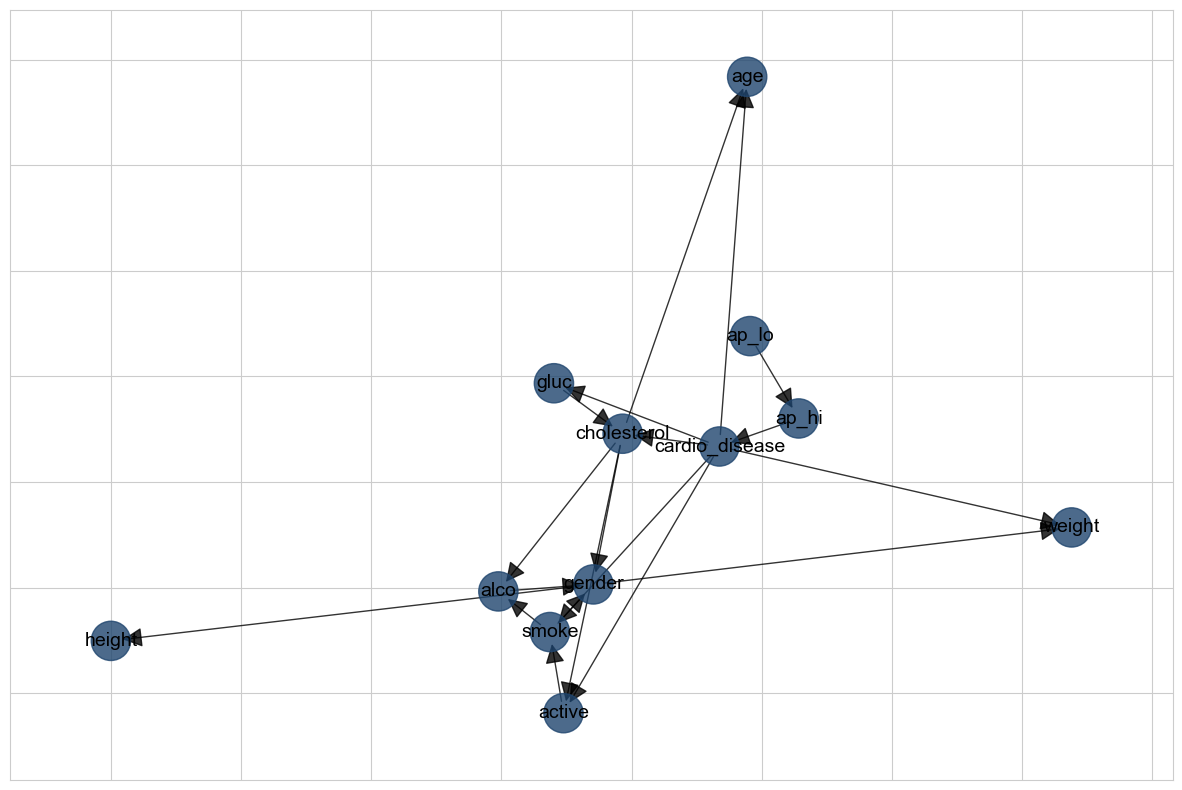

In [29]:
# Parameter learning
model = bn.parameter_learning.fit(DAG, train_data, methodtype='maximumlikelihood')

# Plot
G = bn.plot(model)
# Print CPDs
#CPDs = bn.print_CPD(DAG)
# # Genera le previsioni del modello sui dati di test
# prediction_dataset = test_data.drop("cardio", axis=1)
# y_pred = model.predict(prediction_dataset)

# # Ottieni le etichette reali dal dataset di test
# y_true = test_data['cardio'].values

# # Calcola l'accuracy del modello
# accuracy = accuracy_score(y_true, y_pred)

# print("Accuracy:", accuracy)


In [33]:
from sklearn.metrics import accuracy_score

# Genera le previsioni del modello sui dati di test
prediction_dataset = test_data.drop(["cardio_disease"], axis=1)

y_pred = bn.predict(model, prediction_dataset, variables=["cardio_disease"])
print(y_pred)
# Ottieni le etichette reali dal dataset di test
y_true = test_data['cardio_disease'].values

# Calcola l'accuracy del modello
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy:", accuracy)


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 6172/6172 [00:06<00:00, 931.87it/s]

      cardio_disease         p
0                  0  0.537218
1                  0  0.748680
2                  0  0.670765
3                  0  0.582391
4                  0  0.919710
...              ...       ...
6246               1  0.743354
6247               0  0.512868
6248               0  0.599246
6249               0  0.610409
6250               1  0.962889

[6251 rows x 2 columns]


ValueError: Input y_pred contains NaN.

In [42]:
import numpy as np
np.where(y_pred.isnull())[0]

array([ 179,  197,  765,  947, 1399, 1638, 1688, 1829, 1836, 1884, 1916,
       1990, 2211, 2245, 2430, 2468, 2523, 2622, 2670, 2892, 3149, 3313,
       3415, 3740, 3926, 4336, 4364, 4547, 4647, 4656, 4673, 5078, 5212,
       5430, 5508, 5603, 5635, 5780, 5899, 6075, 6209])

In [45]:
prediction_dataset.iloc[179]

age             50
gender           1
height         159
weight          60
ap_hi          108
ap_lo           75
cholesterol      1
gluc             1
smoke            0
alco             0
active           1
Name: 179, dtype: int64

In [46]:
# Esempio: probabilità di cardio = 1 (cioè malattia cardiovascolare) avendo un paziente di 60 anni, di genere maschile, alto 170 cm, peso 70 kg, con pressione sistolica di 120, pressione diastolica di 80, colesterolo 1, glucosio 1, non fumatore, non alcolista, attivo

q = bn.inference.fit(model, variables=['cardio_disease'], evidence={'age': 50, 'gender': 1, 'height': 159, 'weight': 60, 'ap_hi': 108, 'ap_lo': 75, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1})


[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+------------------+-----+
|    |   cardio_disease |   p |
+====+==================+=====+
|  0 |                0 | nan |
+----+------------------+-----+
|  1 |                1 | nan |
+----+------------------+-----+


### Output and Test